In [1]:
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import pandas as pd

## Lendo os dados

In [2]:
df = pd.read_csv("online_retail.csv")

## Visualizando as 5 primeiras linhas

In [3]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/10 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/10 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/10 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/10 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/10 8:26,3.39,17850.0,United Kingdom


In [4]:
df.shape

(541909, 8)

In [5]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [6]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [7]:
rows_before = len(df)
df.drop_duplicates(inplace=True)

rows_after = len(df)
duplicates_dropped = rows_before - rows_after

print(f"Número de dados removidos: {duplicates_dropped}")


Número de dados removidos: 5268


In [8]:
#Sem o CustomerID, será impossível fazer a segmentação dos clientes, então temos que remover a coluna que é possui o valor Nulo
df = df[df['CustomerID'].notna()]

In [9]:
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [10]:
# Verificando se alguma tem o valor 0
rows_with_zero = df[df['UnitPrice'] <= 0].count()
print(rows_with_zero)

InvoiceNo      40
StockCode      40
Description    40
Quantity       40
InvoiceDate    40
UnitPrice      40
CustomerID     40
Country        40
dtype: int64


In [11]:
# Também vamos remover dados que a coluna do preço seja <= 0, já que toda a analise sera baseada no valor das vendas
df = df[df['UnitPrice'] > 0]

In [12]:
# Verificando se alguma tem o valor 0
rows_with_zero = df[df['UnitPrice'] <= 0].count()
print(rows_with_zero)

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64


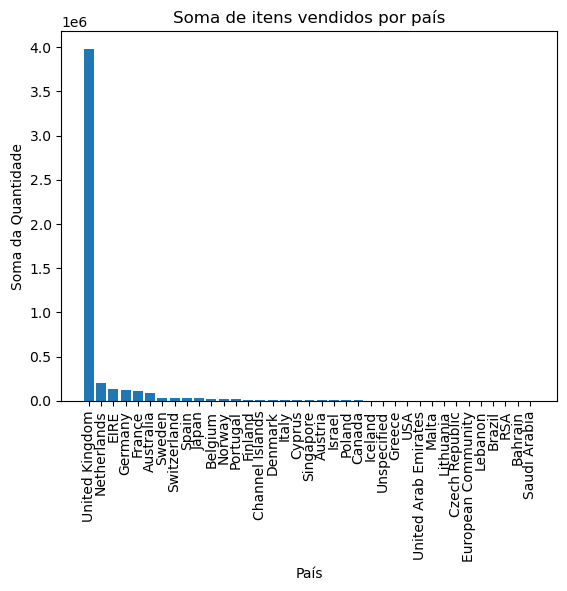

In [13]:
#Vamos ver quais países compram mais
data = df.groupby('Country')['Quantity'].sum()
data.sort_values(ascending=False,inplace=True)
# Create a bar chart with the grouped data
plt.bar(data.index, data.values)
# Set the labels for X and Y axes
plt.xlabel('País')
plt.ylabel('Soma da Quantidade')
# Rotate the x-axis labels for better readability (optional)
plt.xticks(rotation='vertical')
# Set the title of the chart
plt.title('Soma de itens vendidos por país')
# Display the chart
plt.show()

In [14]:
# Como quase todos os dados estão no Reino Unido, é bom remover os outros países para evitar qualquer variação
df = df[df['Country']=='United Kingdom']

In [15]:
print(df.Country.unique())

['United Kingdom']


In [16]:
# A coluna CustomerID está send lida como float, mas o ID sempre deve ser uma string
df['CustomerID'] = df['CustomerID'].astype(int)
df['CustomerID'] = df['CustomerID'].astype(str)

In [17]:
# Mudando a coluna InvoiceData para datetime
df['InvoiceDate']= pd.to_datetime(df['InvoiceDate'])

C:\Users\gabri\AppData\Local\Temp\ipykernel_11124\1811557108.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['InvoiceDate']= pd.to_datetime(df['InvoiceDate'])


In [18]:
# Removendo as quantidades negativas, são pedidos cancelados
df = df[df['Quantity']>0]

In [19]:
#Vamos Criar a coluna Total_price, que será a coluna Quantity * Unit Price
df['Total_Price'] = df['UnitPrice']*df['Quantity']

### Análise Cohort

In [20]:
def get_month(x): return dt.datetime(x.year, x.month, 1)
df['InvoiceMonth'] = df['InvoiceDate'].apply(get_month)
grouping = df.groupby('CustomerID')['InvoiceMonth']
df['CohortMonth'] = grouping.transform('min')

In [21]:
def get_date_int(df, column):
    date = pd.to_datetime(df[column])  # Convert Series to datetime object
    year = date.dt.year
    month = date.dt.month
    day = date.dt.day
    return year, month, day

In [22]:
invoice_year, invoice_month, _ = get_date_int(df, 'InvoiceMonth')
cohort_year, cohort_month, _ = get_date_int(df, 'CohortMonth')
years_diff = invoice_year - cohort_year
months_diff = invoice_month - cohort_month
df['CohortIndex'] = years_diff * 12 + months_diff + 1
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total_Price,InvoiceMonth,CohortMonth,CohortIndex
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,2010-12-01,2010-12-01,1
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010-12-01,2010-12-01,1
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00,2010-12-01,2010-12-01,1
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010-12-01,2010-12-01,1
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010-12-01,2010-12-01,1


In [23]:
#Contando o número de clientes mensais por cohort
grouping = df.groupby(['CohortMonth', 'CohortIndex'])
cohort_data = grouping['CustomerID'].apply(pd.Series.nunique)
cohord_data = cohort_data.reset_index()
cohorts_counts = cohord_data.pivot(index='CohortMonth',
                                  columns='CohortIndex',
                                  values='CustomerID')
cohorts_counts

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12-01,815.0,289.0,263.0,304.0,293.0,323.0,291.0,278.0,289.0,325.0,299.0,405.0,218.0
2011-01-01,358.0,76.0,93.0,84.0,119.0,99.0,90.0,87.0,108.0,117.0,127.0,43.0,NaN
2011-02-01,340.0,64.0,66.0,97.0,98.0,86.0,87.0,96.0,90.0,104.0,25.0,NaN,NaN
2011-03-01,419.0,64.0,109.0,83.0,94.0,69.0,111.0,96.0,119.0,38.0,NaN,NaN,NaN
2011-04-01,277.0,58.0,56.0,60.0,56.0,61.0,61.0,73.0,20.0,NaN,NaN,NaN,NaN
2011-05-01,256.0,48.0,44.0,44.0,53.0,58.0,68.0,23.0,NaN,NaN,NaN,NaN,NaN
2011-06-01,214.0,38.0,31.0,51.0,51.0,69.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,169.0,30.0,33.0,39.0,47.0,18.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,141.0,32.0,32.0,34.0,17.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
cohort_sizes = cohorts_counts.iloc[:,0]
retencao = cohorts_counts.divide(cohort_sizes, axis=0)
retencao.round(3) * 100

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12-01,100.0,35.5,32.3,37.3,36.0,39.6,35.7,34.1,35.5,39.9,36.7,49.7,26.7
2011-01-01,100.0,21.2,26.0,23.5,33.2,27.7,25.1,24.3,30.2,32.7,35.5,12.0,NaN
2011-02-01,100.0,18.8,19.4,28.5,28.8,25.3,25.6,28.2,26.5,30.6,7.4,NaN,NaN
2011-03-01,100.0,15.3,26.0,19.8,22.4,16.5,26.5,22.9,28.4,9.1,NaN,NaN,NaN
2011-04-01,100.0,20.9,20.2,21.7,20.2,22.0,22.0,26.4,7.2,NaN,NaN,NaN,NaN
2011-05-01,100.0,18.8,17.2,17.2,20.7,22.7,26.6,9.0,NaN,NaN,NaN,NaN,NaN
2011-06-01,100.0,17.8,14.5,23.8,23.8,32.2,9.8,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,100.0,17.8,19.5,23.1,27.8,10.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,100.0,22.7,22.7,24.1,12.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


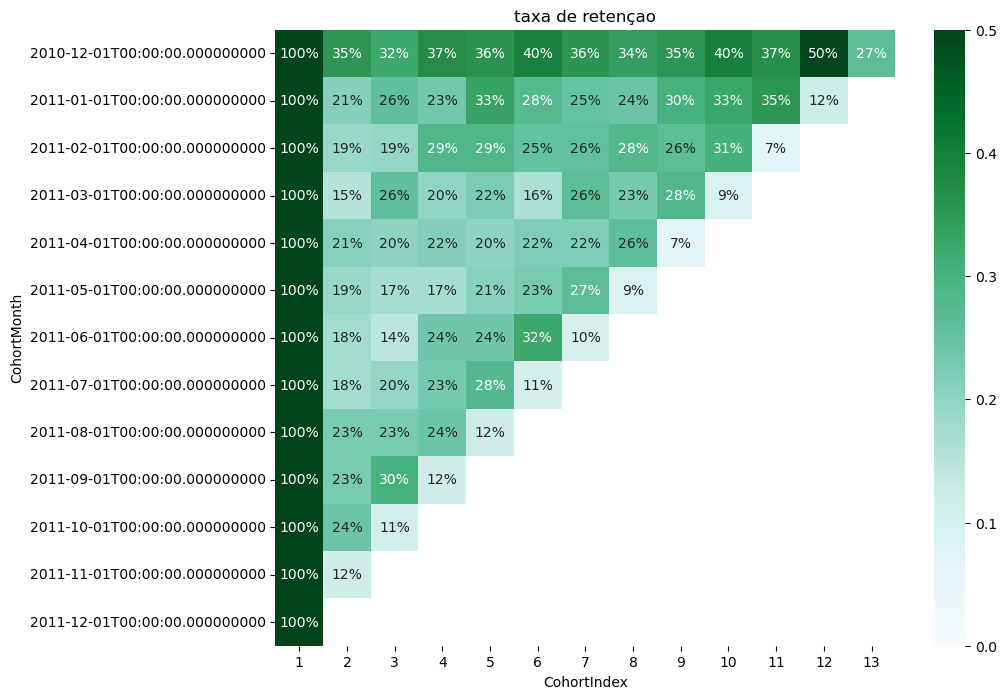

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
plt.title('taxa de retençao')
sns.heatmap(data=retencao,
           annot = True,
           fmt = '.0%',
           vmin = 0.0,
           vmax = 0.5,
           cmap = 'BuGn')
plt.show()

## Transformação dos dados para aplicação do modelo de Machine Learning

In [26]:
# Agora, vamos calcular o RFM dos clientes, que é Recencia (dias desde a ultima compra), frequência (quantas vezes comprou no ultimo mês)
# e o valor monetário (total gasto nos ultimos 12 meses)
print('Min:{}; Max:{}'.format(min(df.InvoiceDate),max(df.InvoiceDate)))
# O dataset tem somente um ano de duração, o que já é perfeito para a analise

Min:2010-12-01 08:26:00; Max:2011-12-09 12:49:00


In [27]:
# Criando uma data referencial
snapshot_date = max(df.InvoiceDate) + dt.timedelta(days=1)

In [28]:
# Agregando os dados por clientes
datamart = df.groupby(['CustomerID']).agg({'InvoiceDate': lambda x: (snapshot_date - x.max()).days, 'InvoiceNo': 'count', 'Total_Price': 'sum'})
datamart

,InvoiceDate,InvoiceNo,Total_Price
CustomerID,,,
12346,326,1,77183.60
12747,2,103,4196.01
12748,1,4412,33053.19
12749,4,199,4090.88
12820,3,59,942.34
...,...,...,...
18280,278,10,180.60
18281,181,7,80.82
18282,8,12,178.05


In [29]:
datamart.rename (columns = {'InvoiceDate': 'Recency', 'InvoiceNo': 'Frequency', 'Total_Price': 'MonetaryValue'}, inplace=True)

In [30]:
datamart
datamart_original = datamart

In [31]:
#recency quartile
r_labels = range(4,0, -1)
r_quartil = pd.qcut(datamart['Recency'], 4, labels = r_labels)
datamart = datamart.assign(R = r_quartil.values)

In [32]:
#frequency quartil
f_labels = range(1,5)
f_quartil = pd.qcut(datamart['Frequency'], 4, labels = f_labels)
datamart = datamart.assign(F = f_quartil.values)

In [33]:
#monetary quartil
m_labels = range(1,5)
m_quartil = pd.qcut(datamart['Frequency'], 4, labels = m_labels)
datamart = datamart.assign(M = m_quartil.values)

In [34]:
def join_rfm(x):
    return str(int(x['R'])) + str(int(x['F'])) + str(int(x['M']))
datamart['RFM_Segment'] = datamart.apply(join_rfm, axis=1)
datamart['RFM_Score'] = datamart[['R','F','M']].sum(axis=1)

In [35]:
datamart

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment,RFM_Score
CustomerID,,,,,,,,
12346,326,1,77183.60,1,1,1,111,3
12747,2,103,4196.01,4,4,4,444,12
12748,1,4412,33053.19,4,4,4,444,12
12749,4,199,4090.88,4,4,4,444,12
12820,3,59,942.34,4,3,3,433,10
...,...,...,...,...,...,...,...,...
18280,278,10,180.60,1,1,1,111,3
18281,181,7,80.82,1,1,1,111,3
18282,8,12,178.05,4,1,1,411,6


In [36]:
# Vendo o tamanho de cada segmento, para ver se não tem nenhum outlier
datamart.groupby('RFM_Segment').size().sort_values(ascending=False)[:10]

RFM_Segment
444    510
111    477
122    303
333    298
211    287
344    279
222    269
433    269
233    267
322    214
dtype: int64

In [37]:
# Resumo das métricas, agrupada pelo score do RFM
datamart.groupby('RFM_Score').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': ['mean', 'count']}).round(1)


Recency Frequency MonetaryValue      
             mean      mean          mean count
RFM_Score                                      
3           256.8       8.6         596.1   477
4            86.9       9.2         425.7   287
5           168.8      20.4         426.6   470
6            65.9      22.9        1098.1   369
7           115.8      42.4         681.2   369
8            58.1      50.9        1026.6   412
9            53.3      76.9        1343.6   339
10           32.0      98.0        2018.3   408
11           31.4     205.8        3026.9   279
12            7.5     322.2        6813.7   510

In [38]:
# Esse foi um jeito "manual" de fazer, agora vamos usar o algoritmo K-means
# Antes disso, temos que checar se os dados possuem uma distribuição simétrica
# Variaveis tem o mesmo valor médio
# Variaveis com a mesma variância
# Aplicar transformação logaritmica, que só funciona em valores positivos

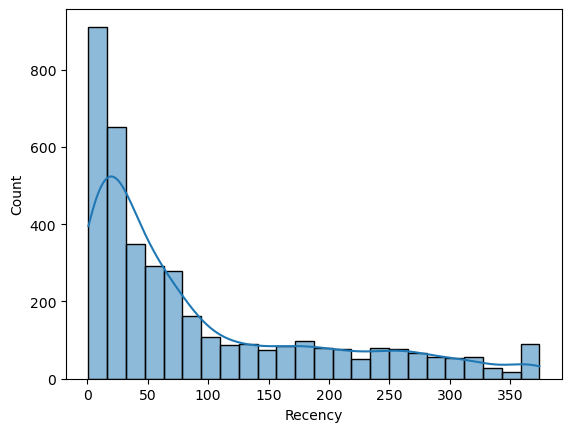

In [39]:
#Vamos ver se a distribuiçao é simetrica, pra cada variavel
import seaborn as sns
sns.histplot(datamart['Recency'],kde=True)
plt.show()

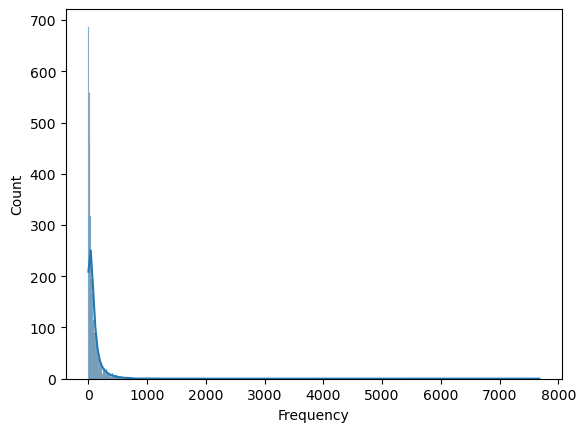

In [40]:
sns.histplot(datamart['Frequency'], kde=True)
plt.show()

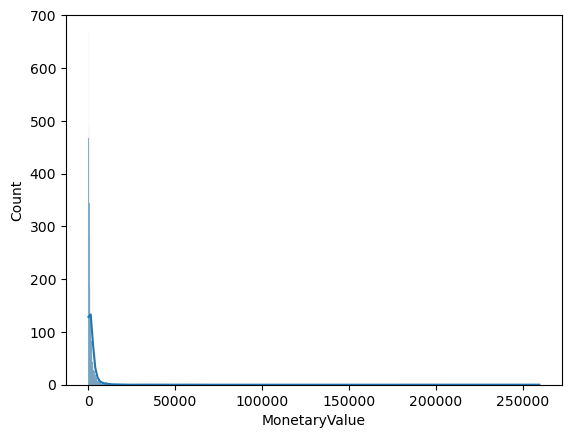

In [41]:
sns.histplot(datamart['MonetaryValue'], kde=True)
plt.show()

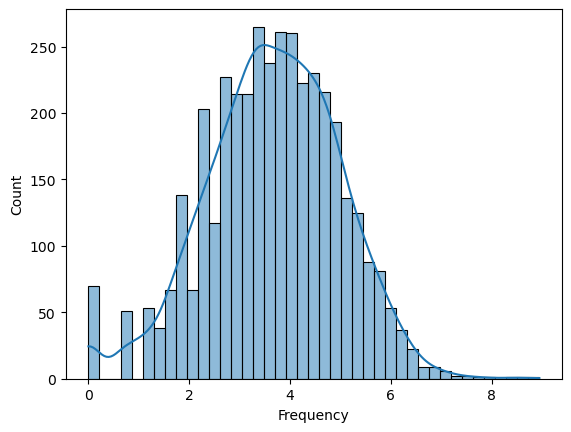

In [42]:
# Transformando os dados usando a transformação logaritimica
frequencia_log= np.log(datamart['Frequency'])
sns.histplot(frequencia_log, kde=True)
plt.show()


In [43]:
datamart_rfm = datamart[['Recency', 'Frequency',  'MonetaryValue']]
datamart_rfm.describe()

,Recency,Frequency,MonetaryValue
count,3920.000000,3920.000000,3920.000000
mean,92.208418,89.082398,1858.424654
std,99.533854,214.034542,7478.631256
min,1.000000,1.000000,3.750000
25%,18.000000,17.000000,298.185000
50%,51.000000,40.000000,644.975000
75%,143.000000,98.000000,1571.285000
max,374.000000,7676.000000,259657.300000


In [44]:
# Comparando as médias
datamart_centered = datamart_rfm - datamart_rfm.mean()
datamart_centered.describe().round(2)

,Recency,Frequency,MonetaryValue
count,3920.00,3920.00,3920.00
mean,-0.00,-0.00,0.00
std,99.53,214.03,7478.63
min,-91.21,-88.08,-1854.67
25%,-74.21,-72.08,-1560.24
50%,-41.21,-49.08,-1213.45
75%,50.79,8.92,-287.14
max,281.79,7586.92,257798.88


In [45]:
# Comparando o desvio padrão
datamart_scaled = datamart_rfm / datamart_rfm.std()
datamart_scaled.describe().round(2)

,Recency,Frequency,MonetaryValue
count,3920.00,3920.00,3920.00
mean,0.93,0.42,0.25
std,1.00,1.00,1.00
min,0.01,0.00,0.00
25%,0.18,0.08,0.04
50%,0.51,0.19,0.09
75%,1.44,0.46,0.21
max,3.76,35.86,34.72


## Aplicando o KMeans

In [46]:
import numpy as np
datamart_log = np.log(datamart_rfm)

In [47]:
zero_values = (datamart_rfm == 0)
print(zero_values.sum())

Recency          0
Frequency        0
MonetaryValue    0
dtype: int64


In [48]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(datamart_log)

StandardScaler()

In [49]:
# Armazenar os dados
datamart_normalizado = scaler.transform(datamart_log)

In [50]:
#implementando o kmeans para tres clusters
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=1)

In [51]:
kmeans.fit(datamart_normalizado)

C:\Users\gabri\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=3, random_state=1)

In [52]:
cluster_labels = kmeans.labels_

In [53]:
datamart_rfm_k3 = datamart_rfm.assign(Cluster = cluster_labels)

In [54]:
datamart_rfm_k3.groupby(['Cluster']).agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': ['mean','count'],
}).round(0)

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0          68.0      67.0        1147.0  1673
1          12.0     258.0        5903.0   841
2         169.0      15.0         285.0  1406

In [55]:
datamart_normalizado = pd.DataFrame(datamart_normalizado,
                                   index=datamart_rfm.index,
                                   columns=datamart_rfm.columns)
datamart_normalizado['Cluster'] = datamart_rfm_k3['Cluster']


In [56]:
datamart_melt = pd.melt(datamart_normalizado.reset_index(),
                       id_vars=['CustomerID', 'Cluster'],
                       value_vars=['Recency', 'Frequency', 'MonetaryValue'],
                       var_name='Attribute',
                       value_name='Value')

<Axes: title={'center': 'Snake plot of standardized variables'}, xlabel='Attribute', ylabel='Value'>

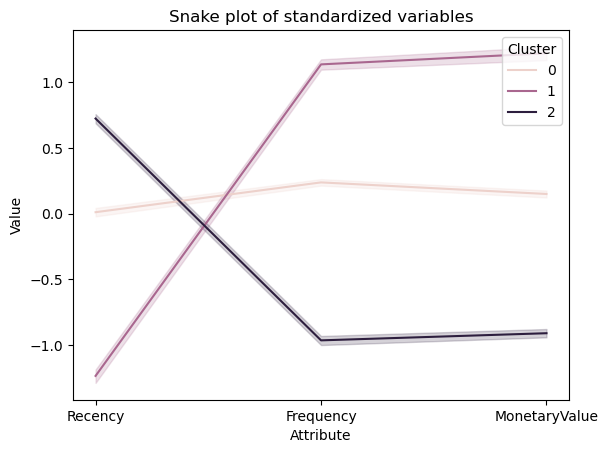

In [57]:
#Plotando o snakeplot
plt.title('Snake plot of standardized variables')
sns.lineplot(x='Attribute', y='Value', hue='Cluster', data=datamart_melt)